# Photocatalytic Micelles

Photocatalytic system which forms micelles in water and catalyses the reduction of CO$_2$ and H$_2$O to CO and H$_2$, respectively. The system is comprised of the following components:
- catalyst ('Cat')
- photosensitiser ('PS')
- surfactant ('Surf.')
- reductant ('Red.')
- buffer ('Buf')

The concentration of each component was varied and the turn over frequency (TOF) of CO ('TOFCO / min−1') was measured. Hence, the concentrations of each component can be modelled to predict the TOF of CO.
This dataset was obtained from the following publication: https://doi.org/10.1021/jacs.4c01305

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
import joblib
import shap

In [2]:
# import data
df = pd.read_excel('Original Working Datatable.xlsx', sheet_name='SI Tab 3 SLA')
df

,Unnamed: 0,Cat/,PS,Surf.,Red.,Buf,CO / µmol,Unnamed: 7,Unnamed: 8,TONCO,Unnamed: 10,TOFCO / min−1,Unnamed: 12,Quant. Yield,Unnamed: 14,Sel CO:H2,Unnamed: 16,A456 nm,Unnamed: 18,Unnamed: 19
0,#,µM,µM,CMC,mM,mM,Mean,±SD,%RSD,Mean,±SD,Mean,±SD,Mean,±SD,Mean,±SD,0 min,15 min,% Change
1,1*,1.5,30,3,100,100,0.37,0.06,17,249,38,17,2,0.04,0.01,87,2,0.385±0.03,0.27±0.04,0.7
2,2*,1.5,10,3,100,100,0.18,0.02,11,119,17,8,1,0.019,0.003,88,1,0.16,0.08,0.5
3,3*,1.5,50,3,100,100,0.37,0.03,8,243,20,16,1,0.039,0.003,89,1,0.58,0.45,0.78
4,4*,1.5,100,3,100,100,0.218,0.008,4,146,5,9.7,0.3,0.0231,0.0008,89,0,1.05,1.04,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,99,4.7,118,16,200,597,0.72,0.04,6,154,7,10.3,0.5,0.077,0.004,88,1,1.435,1.258,0.88
100,100,4.7,102,21,172,482,1.26,0.04,3,269,9,17.9,0.6,0.133,0.005,87,1,1.316,1.018,0.77
101,101,3.2,100,23,176,484,0.921,0.002,0,288,1,19.2,0.05,0.0974,0.0002,88,1,1.23,1.014,0.82
102,102,6.2,139,13,404,698,0.26,0.02,8,42,3,2.8,0.2,0.027,0.002,83,1,1.354,0.353,0.26


In [3]:
# clean data
new_cols = []

# take column name and add the next row element to it
for col in df.columns:
    new_col = str(col) + '_' + str(df.loc[0, col])
    new_cols.append(new_col)
    
df.columns = new_cols

#drop first row and first column
df.drop(0, axis=0, inplace=True)
df.drop(df.columns[0], axis=1, inplace=True)

drop_cols = ['CO / µmol_Mean', 'Unnamed: 7_±SD', 'Unnamed: 8_%RSD', 'TONCO_Mean', 'Unnamed: 10_±SD',
             'Unnamed: 12_±SD', 'Quant. Yield_Mean', 'Unnamed: 14_±SD', 'Sel CO:H2_Mean', 'Unnamed: 16_±SD',
             'A456 nm_0 min', 'Unnamed: 18_15 min', 'Unnamed: 19_ % Change']

df0 = df.drop(drop_cols, axis=1).astype(float)
df0

,Cat/_µM,PS_µM,Surf._CMC,Red._mM,Buf_mM,TOFCO / min−1_Mean
1,1.5,30.0,3.0,100.0,100.0,17.0
2,1.5,10.0,3.0,100.0,100.0,8.0
3,1.5,50.0,3.0,100.0,100.0,16.0
4,1.5,100.0,3.0,100.0,100.0,9.7
5,1.5,30.0,1.0,100.0,100.0,8.7
...,...,...,...,...,...,...
99,4.7,118.0,16.0,200.0,597.0,10.3
100,4.7,102.0,21.0,172.0,482.0,17.9
101,3.2,100.0,23.0,176.0,484.0,19.2
102,6.2,139.0,13.0,404.0,698.0,2.8


In [4]:
df0.describe()

,Cat/_µM,PS_µM,Surf._CMC,Red._mM,Buf_mM,TOFCO / min−1_Mean
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,4.571845,96.378641,19.436893,212.466019,455.417476,12.247670
std,2.164029,33.537838,9.173352,99.707889,210.805994,6.870834
min,1.500000,10.000000,1.000000,1.000000,10.000000,0.000000
25%,2.900000,86.000000,13.000000,170.000000,320.500000,6.935000
50%,4.500000,103.000000,21.000000,190.000000,494.000000,11.800000
75%,6.200000,115.000000,26.000000,251.000000,588.500000,18.000000
max,9.800000,180.000000,38.000000,500.000000,1000.000000,28.100000


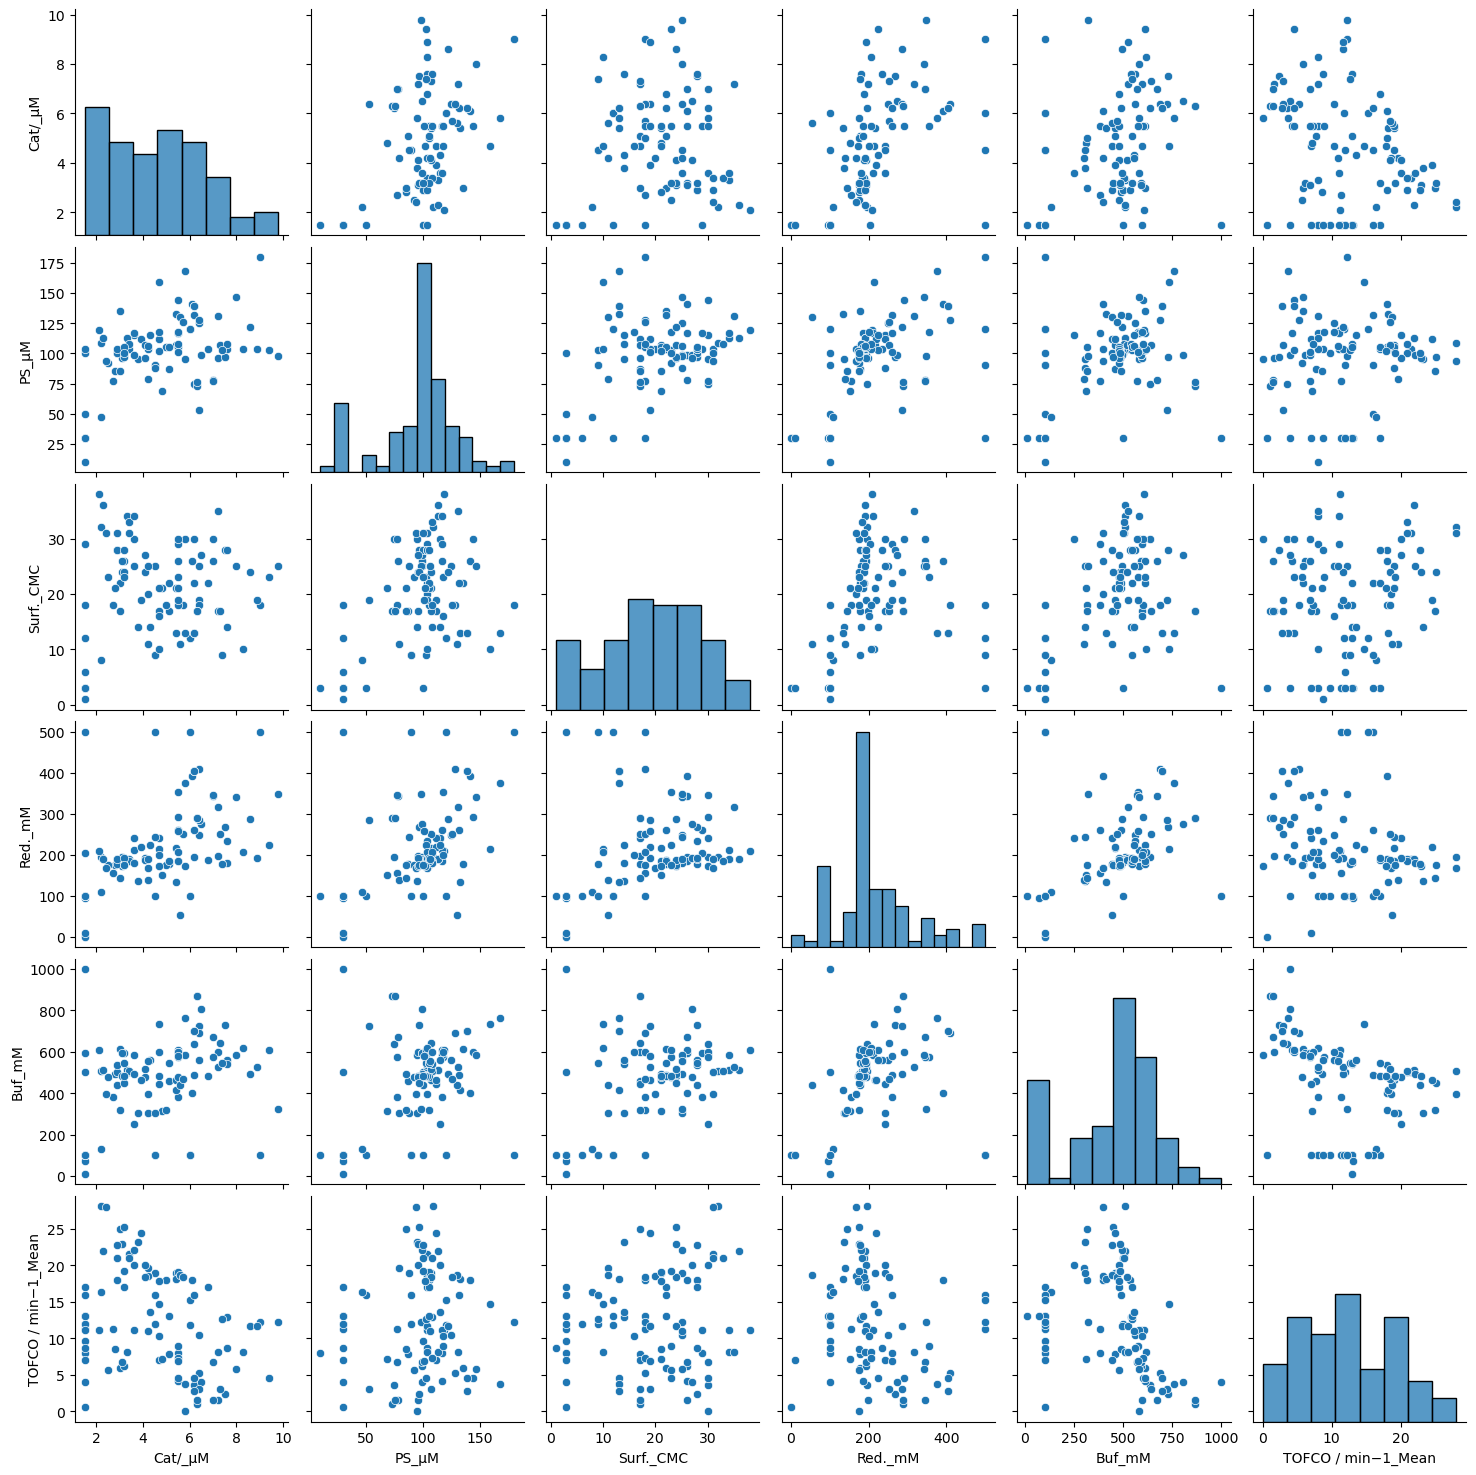

In [6]:
# visualise the data
sns.pairplot(data=df0)

In [ ]:
# create X and y
X = df0.drop('TOFCO / min−1_Mean', axis=1).astype(float)
y = df0['TOFCO / min−1_Mean'].astype(float)

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=31, random_state=33)

In [10]:
# gridsearch for hyperparameter tuning
hyperparams = {'n_estimators': [100, 200, 500, 1000, 2000],
              'max_features': [1.0, 'sqrt', 'log2']}

gridsearch = GridSearchCV(rfr, hyperparams)

gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_features': [1.0, 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 500, 1000, 2000]})

In [26]:
# take best estimator
model = gridsearch.best_estimator_
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f'Train score: {train_score:.2f}\nTest score: {test_score:.2f}')

Train score: 0.91
Test score: 0.80


In [27]:
# save the model
joblib.dump(model, 'randomforestregressor_model_1.pkl')

['randomforestregressor_model_1.pkl']

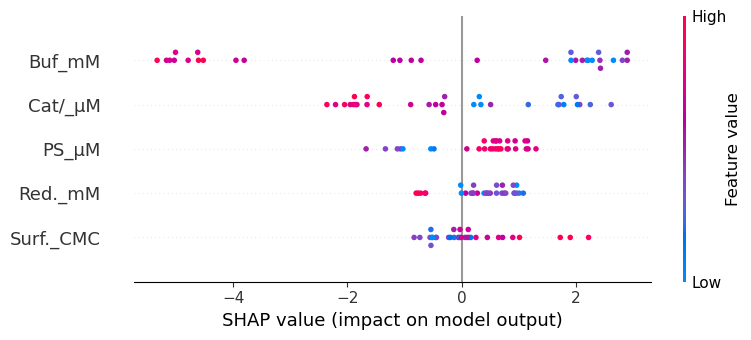

In [32]:
# shap analysis to extract feature importance
# create TreeExplainer
explainer = shap.TreeExplainer(model)

# calculate shap values
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

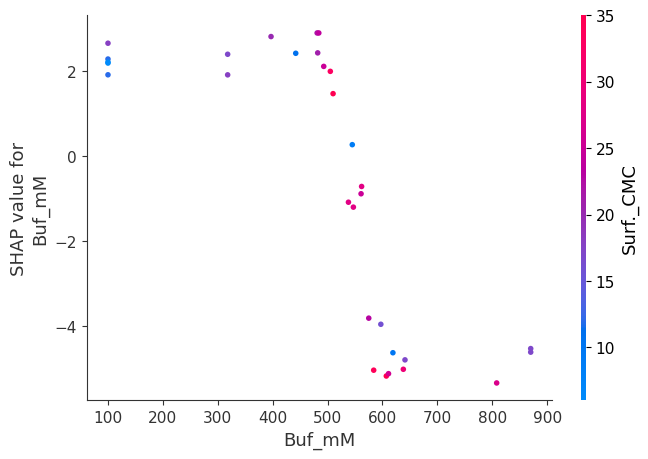

In [33]:
shap.dependence_plot("Buf_mM", shap_values, X_test)

The model predicts the buffer concentration as the most important feature affecting TOF, whereby low buffer concentrations increase the TOF until ~550 mM, after which increasing the buffer concentrations negatively impacts the TOF. This can be rationalised by the micelles salting out at high buffer concentrations, which hinders catalysis.